### Importing the step:

In [12]:
import pandas as pd
from datetime import datetime

In [93]:
import numpy as np
from scipy.stats.distributions import chi2 
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels

from pmdarima.arima import auto_arima ,ndiffs
from pmdarima.arima import OCSBTest 
import pmdarima

In [116]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [67]:
df=pd.read_csv("../data/GBPAUD_step0.csv")
df.set_index("Unnamed: 0", drop=True, append=False, inplace=True)

In [68]:
df.shape

(3094, 4)

In [69]:
df.index[0]

'2021-11-01 00:00:00+00:00'

In [70]:
df.tail()

,Open,High,Low,Close
Unnamed: 0,,,,
2022-04-29 18:00:00+01:00,1.77544,1.77717,1.77406,1.77567
2022-04-29 19:00:00+01:00,1.77567,1.77928,1.77506,1.77894
2022-04-29 20:00:00+01:00,1.77899,1.78041,1.77733,1.77992
2022-04-29 21:00:00+01:00,1.77995,1.78175,1.77690,1.78013
2022-04-29 22:00:00+01:00,1.77982,1.77982,1.77982,1.77982


In [71]:
df_exog=df[["Low","High","Open"]]
df=df.drop( columns=["Low","High","Open"])

In [72]:
df_exog

,Low,High,Open
Unnamed: 0,,,
2021-11-01 00:00:00+00:00,1.81838,1.82120,1.81997
2021-11-01 01:00:00+00:00,1.81967,1.82187,1.82053
2021-11-01 02:00:00+00:00,1.82013,1.82232,1.82051
2021-11-01 03:00:00+00:00,1.82088,1.82272,1.82144
2021-11-01 04:00:00+00:00,1.82166,1.82329,1.82246
...,...,...,...
2022-04-29 18:00:00+01:00,1.77406,1.77717,1.77544
2022-04-29 19:00:00+01:00,1.77506,1.77928,1.77567
2022-04-29 20:00:00+01:00,1.77733,1.78041,1.77899


In [73]:
df

,Close
Unnamed: 0,
2021-11-01 00:00:00+00:00,1.82042
2021-11-01 01:00:00+00:00,1.82051
2021-11-01 02:00:00+00:00,1.82137
2021-11-01 03:00:00+00:00,1.82246
2021-11-01 04:00:00+00:00,1.82220
...,...
2022-04-29 18:00:00+01:00,1.77567
2022-04-29 19:00:00+01:00,1.77894
2022-04-29 20:00:00+01:00,1.77992


In [98]:
#assigning the frequency to business days
#df = df.asfreq('1h')
#checking for missing values 
print(df.isna().sum())
#filling them with the last known value
df = df.fillna(method='bfill')
#rechecking for missing values 
print(df.isna().sum())

Close      0
returns    1
dtype: int64
Close      0
returns    0
dtype: int64


In [75]:
for i in range(len(df)):
    df["Close"][i]=float(df["Close"][i])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165


In [76]:
df.dtypes

Close    float64
dtype: object

In [79]:
df['returns'] = list(df['Close'].pct_change(1).mul(100))
df.head()

,Close,returns
Unnamed: 0,,
2021-11-01 00:00:00+00:00,1.82042,NaN
2021-11-01 01:00:00+00:00,1.82051,0.004944
2021-11-01 02:00:00+00:00,1.82137,0.047238
2021-11-01 03:00:00+00:00,1.82246,0.059848
2021-11-01 04:00:00+00:00,1.82220,-0.014273


<AxesSubplot:xlabel='Unnamed: 0'>

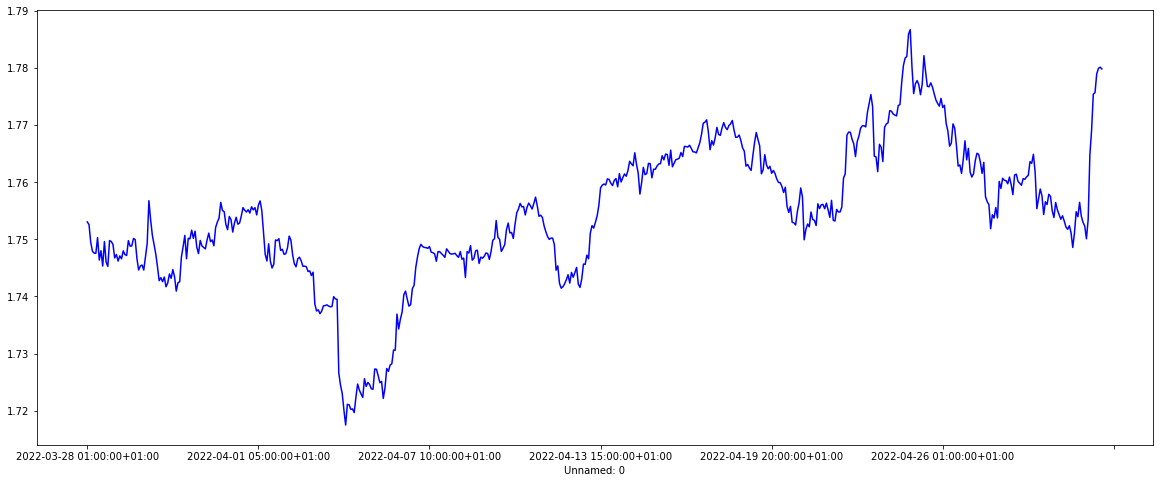

In [85]:
df["Close"][2500:].plot(figsize= (20,8), color = "blue")


<AxesSubplot:xlabel='Unnamed: 0'>

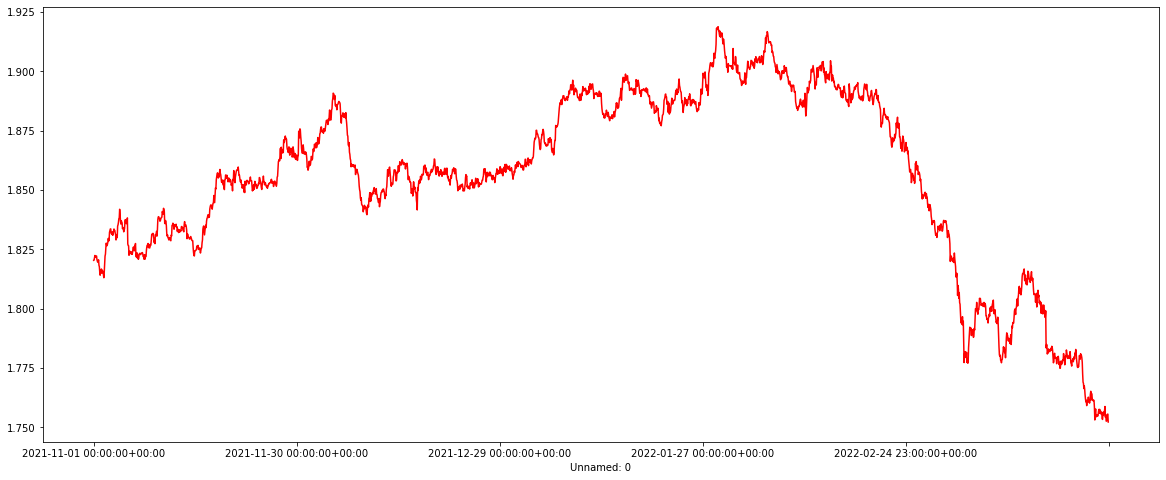

In [86]:
df["Close"][:2500].plot(figsize= (20,8), color = "red")

In [87]:
# Creating Returns
pmdarima.arima.ndiffs(df[["Close"]], alpha=0.05, test='kpss', max_d=4)

1

In [91]:
sts.adfuller(df['returns'][1:])[1]>0.05

False

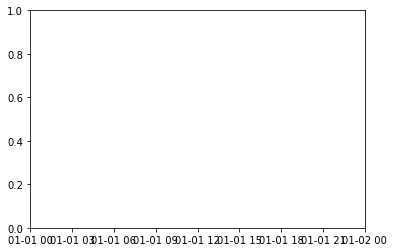

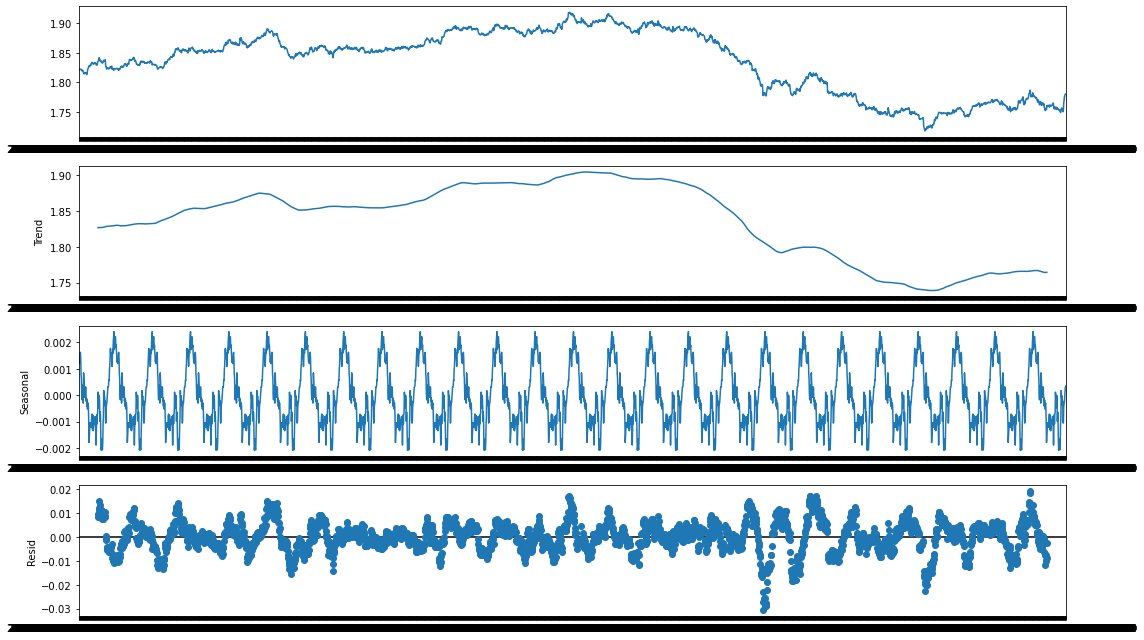

In [106]:
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

ax = plt.axes()
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)

decomp_viz=statsmodels.tsa.seasonal.seasonal_decompose(df[["Close"]],model='additive',period=120)
fig = decomp_viz.plot()

fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [107]:
size = int(len(df['Close'])*0.8)
df_new_train = pd.DataFrame(index=df['Close'].iloc[:size].index)
df_new_test = pd.DataFrame(index=df['Close'].iloc[:size].index)
df_new_train['Close'], df_new_test['Close'] = df['Close'].iloc[:size], df['Close'].iloc[size:]

In [111]:
df_exog_train = pd.DataFrame(index=df_exog.iloc[:size].index)
df_exog_test = pd.DataFrame(index=df_exog.iloc[:size].index)
df_exog_train, df_exog_test = df_exog.iloc[:size], df_exog.iloc[size:]

In [112]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [117]:
#fitting a simple ARIMAX (1,0,1) #no integration seems to be required since TS is assumed to be stationary
mod_cad_0=ARIMA(df_new_train['Close'] , exog =df_exog_train , order=(1,0,1))

C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it

In [118]:
results_mod_cad_0 = mod_cad_0.fit()
results_mod_cad_0.summary()

C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\statsmodels\tsa\arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2475
Model:                     ARMA(1, 1)   Log Likelihood               14064.985
Method:                       css-mle   S.D. of innovations              0.001
Date:                Sun, 29 May 2022   AIC                         -28115.970
Time:                        19:08:34   BIC                         -28075.272
Sample:                             0   HQIC                        -28101.188
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0010      0.001     -1.463      0.143      -0.002       0.000
Low             0.7451      0.002    357.472      0.000       0.741       0.749
High            0.7788      0.002    414.121      0.000       0.775       0.782
Open           -0.5232        nan        nan        nan         nan         nan
ar.L1.Close     0.0101        nan        nan        nan         nan         nan
ma.L1.Close     0.0102        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           98.5499           +0.0000j           98.5499            0.0000
MA.1          -98.2416           +0.0000j           98.2416            0.5000
-----------------------------------------------------------------------------
"""

In [119]:
df_new_train["residuals_ARMAX1_1"]=results_mod_cad_0.resid
df_new_train.head()

,Close,residuals_ARMAX1_1
Unnamed: 0,,
2021-11-01 00:00:00+00:00,1.82042,0.000602
2021-11-01 01:00:00+00:00,1.82051,-0.000511
2021-11-01 02:00:00+00:00,1.82137,-0.000332
2021-11-01 03:00:00+00:00,1.82246,0.000371
2021-11-01 04:00:00+00:00,1.82220,-0.000395


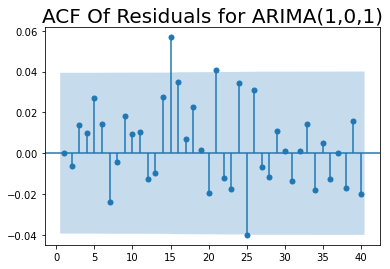

In [120]:
sgt.plot_acf(df_new_train.residuals_ARMAX1_1, zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,0,1)",size=20)
plt.show()
#we would expect it the result to be mostly insignificant lags that resemble white noise

In [124]:
model_ar_1_i_1_ma_2 = ARIMA(df_new_train["Close"], exog =df_exog_train,order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
model_ar_1_i_1_ma_3 = ARIMA(df_new_train["Close"],exog =df_exog_train, order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()
model_ar_2_i_1_ma_1 = ARIMA(df_new_train["Close"], exog =df_exog_train,order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
model_ar_3_i_1_ma_1 = ARIMA(df_new_train["Close"],exog =df_exog_train, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_3_i_1_ma_2 = ARIMA(df_new_train["Close"],exog =df_exog_train, order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit(start_ar_lags=5)

C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Aymen\.co

In [125]:
print("ARIMAX(1,0,1):  \t LL = ", results_mod_cad_0.llf, "\t AIC = ", results_mod_cad_0.aic)
print("ARIMAX(1,1,2):  \t LL = ", results_ar_1_i_1_ma_2.llf, "\t AIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMAX(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMAX(2,1,1):  \t LL = ", results_ar_2_i_1_ma_1.llf, "\t AIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMAX(3,1,1):  \t LL = ", results_ar_3_i_1_ma_1.llf, "\t AIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMAX(3,1,2):  \t LL = ", results_ar_3_i_1_ma_2.llf, "\t AIC = ", results_ar_3_i_1_ma_2.aic)

ARIMAX(1,0,1):  	 LL =  14064.985206723972 	 AIC =  -28115.970413447943
ARIMAX(1,1,2):  	 LL =  13863.291479141837 	 AIC =  -27710.582958283674
ARIMAX(1,1,3):  	 LL =  13864.070305447662 	 AIC =  -27710.140610895323
ARIMAX(2,1,1):  	 LL =  13863.288432787362 	 AIC =  -27710.576865574723
ARIMAX(3,1,1):  	 LL =  13864.119483890638 	 AIC =  -27710.238967781275
ARIMAX(3,1,2):  	 LL =  13865.171932099463 	 AIC =  -27710.343864198927


In [141]:
#ARIMAX(1,0,1) and ARIMAX(2,1,1) seem to be in the lead with the highest LLR and lowest AIC, we run the Log likelihood test
#while keeping in mind a simpler model is always preferred to a more complex one if they give similer results (we want to avoid overfitting)
#
LLR_test(mod_cad_0,model_ar_2_i_1_ma_1, DF = 4)

C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
war

1.0

In [155]:
r=results_mod_cad_0.predict(
    int(len(df['Close'])*0.2),
    exog=df_exog_test)
print(r)

Unnamed: 0
2021-12-06 23:00:00+00:00    1.881272
2021-12-07 00:00:00+00:00    1.882910
2021-12-07 01:00:00+00:00    1.881174
2021-12-07 02:00:00+00:00    1.883498
2021-12-07 03:00:00+00:00    1.879511
                               ...   
2022-03-24 18:00:00+00:00    1.753640
2022-03-24 19:00:00+00:00    1.754991
2022-03-24 20:00:00+00:00    1.754491
2022-03-24 21:00:00+00:00    1.754745
2022-03-24 22:00:00+00:00    1.754960
Length: 1857, dtype: float64


In [196]:
df_pred_pr = pd.DataFrame( results_mod_cad_0.predict(int(len(df['Close'])*0.2),exog=df_exog_test), index = df.index)
df_pred_pr['predictions']=results_mod_cad_0.predict(int(len(df['Close'])*0.2))

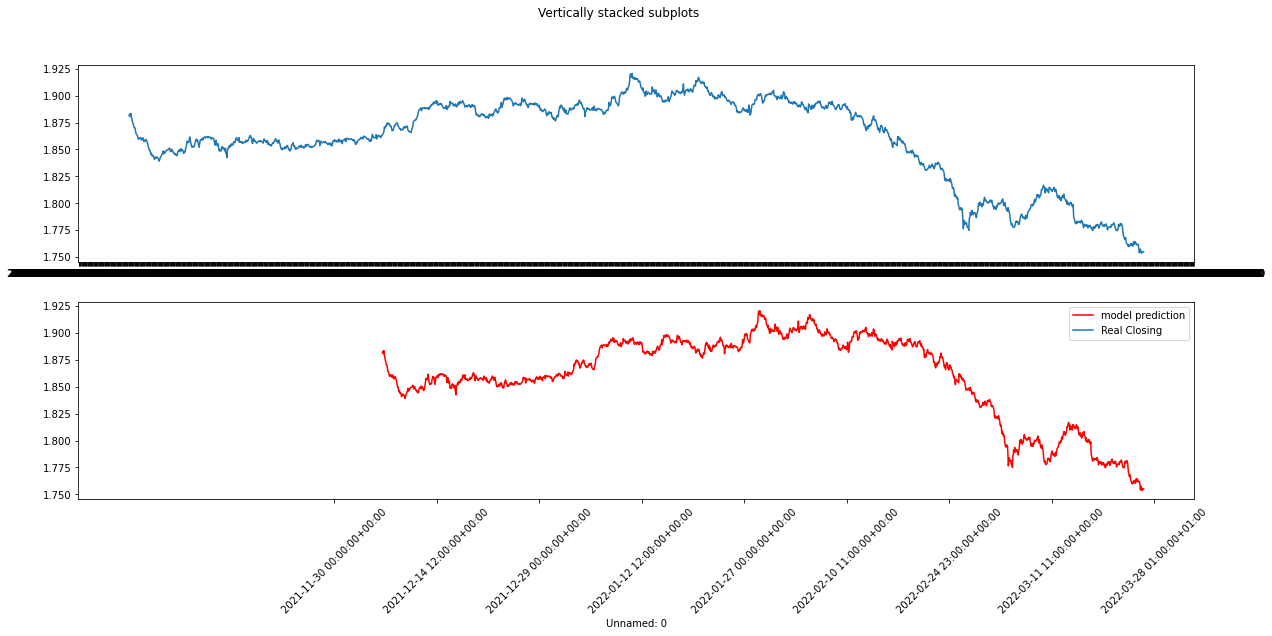

In [176]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')

df_pred_pr['predictions'].plot(figsize = (20,8), color = "red")
#(df["Close"].iloc[int(len(df['Close'])*0.2)],color = "blue")
ax1.plot( df_pred_pr['predictions'])
ax2.plot( df["Close"].iloc[int(len(df['Close'])*0.2)])

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.legend(['model prediction','Real Closing'])
plt.xticks(rotation = 45)
plt.show()

In [177]:
len(df_pred_pr['predictions'])

3094

In [180]:
df["Close"].iloc[int(len(df['Close'])*0.2)].shape

()

In [183]:
from arch.univariate import StudentsT
from arch.univariate import GARCH, ConstantMean, SkewStudent
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from arch import arch_model

In [186]:
mod_garch = arch_model(df.returns[2:]*10, vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
mod_garch.distribution = StudentsT()
res_garch = mod_garch.fit( update_freq = 10) #last_obs = start_date,

mod_arch = arch_model(df.returns[2:]*10, vol = "GARCH", p = 1, q = 0, mean = "constant", dist = "Normal")
mod_arch.distribution = StudentsT()
res_arch = mod_arch.fit( update_freq = 10) #last_obs = start_date,

Iteration:     10,   Func. Count:     71,   Neg. LLF: 4218.483042145183
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4218.4830421451725
            Iterations: 10
            Function evaluations: 71
            Gradient evaluations: 10
Iteration:     10,   Func. Count:     64,   Neg. LLF: 4236.5920696197845
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4236.574279331588
            Iterations: 15
            Function evaluations: 88
            Gradient evaluations: 15


In [187]:
print(res_garch.summary(),res_arch.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4218.48
Distribution:      Standardized Student's t   AIC:                           8446.97
Method:                  Maximum Likelihood   BIC:                           8477.15
                                              No. Observations:                 3092
Date:                      Sun, May 29 2022   Df Residuals:                     3091
Time:                              21:45:03   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

In [188]:
print(res_garch.params)

mu         -0.008082
omega       0.223215
alpha[1]    0.118542
beta[1]     0.666512
nu          5.129509
Name: params, dtype: float64


In [189]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target' , reindex=False)

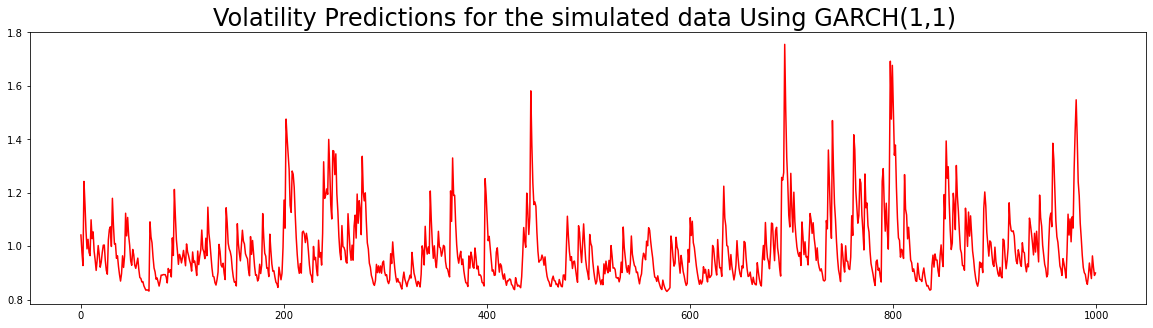

In [192]:
sim_data = mod_garch.simulate(res_garch.params, 1000)
sim_data.volatility.plot(figsize = (20,5), color = "red", zorder = 2)
plt.title("Volatility Predictions for the simulated data Using GARCH(1,1) ", size = 24)
#1 normal arch apramater and 1 corrective past error term 
#this is proven to be the best model as higher order ones will recursively include the other correctif terms that are are encapsulated in 'yesterday' 's error term (n-1)th
plt.show()

In [198]:
df_pred_pr['predictions'].head()

Unnamed: 0
2021-11-01 00:00:00+00:00   NaN
2021-11-01 01:00:00+00:00   NaN
2021-11-01 02:00:00+00:00   NaN
2021-11-01 03:00:00+00:00   NaN
2021-11-01 04:00:00+00:00   NaN
Name: predictions, dtype: float64

In [199]:
sim_data.head()

,data,volatility,errors
0,-0.291557,1.042119,-0.283475
1,-0.029170,0.978049,-0.021088
2,2.502282,0.927815,2.510364
3,-0.854535,1.242585,-0.846453
4,-0.131672,1.156398,-0.123590


In [ ]:
#if the prediction volatility surpasses 1.15 we should add a multiplicative 